In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [2]:
penguins = sns.load_dataset('penguins')

# 결측치 제거
penguins = penguins.dropna().reset_index(drop = True)

In [4]:
# 이전에 분류 분석 노트북에서 작성한 것과 동일(모델은 Logistic Regression 사용)

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

scaler = MinMaxScaler()

features = penguins[['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']]
features_normed = scaler.fit_transform(features)

penguins = penguins.assign(bill_length_mm = features_normed[:, 0],
                          bill_depth_mm = features_normed[:, 1],
                          flipper_length_mm = features_normed[:, 2],
                          body_mass_g = features_normed[:, 3])

encoder = LabelEncoder()

features = penguins[['species', 'island', 'sex']]
encoded = features.apply(encoder.fit_transform)

penguins = penguins.assign(species = encoded['species'],
                          island = encoded['island'],
                          sex = encoded['sex'])

X = penguins.drop('sex', axis = 1)
y = penguins['sex']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = True)

lr_model = LogisticRegression(verbose = 0)
lr_model.fit(X_train, y_train)

# male = 1, female = 0
predictions = lr_model.predict(X_test)

acc = accuracy_score(y_test, predictions)
print('Logisctic Regression 모델의 예측 정확도는 {}% 입니다.'.format(round(acc * 100)))

Logisctic Regression 모델의 예측 정확도는 94% 입니다.


- accuracy_score 정확도는 94%라고 나왔지만 정확도만을 가지고 분류 성능을 평가하는 것은 주의가 필요함
- 만약 10마리 중에 9마리가 male, 1마리가 female이라면 전부 male로 예측해도 정확도는 90%로 나옴
- 따라서 추가적으로 다른 성능평가 지표 확인

# 오차행렬(confusion matrix)

- 예측 = True, 실제 = True => TP(true positive)
- 예측 = True, 실제 = False => FP(false positive)

- 예측 = False, 실제 = True => FN(false negative)
- 예측 = False, 실제 = False => TN(true negative)

In [6]:
# pip install mlxtend

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [7]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

In [8]:
# male = 1, female = 0

predictions = lr_model.predict(X_test)

In [9]:
# confusion matrix

cnf_matrix = confusion_matrix(y_test, predictions)
cnf_matrix

array([[31,  3],
       [ 1, 32]], dtype=int64)

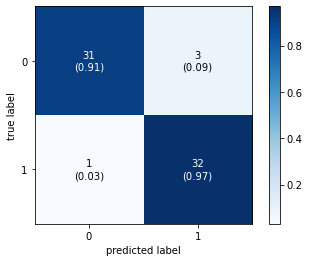

In [10]:
# confusion matrix 시각화

figure, ax = plot_confusion_matrix(conf_mat = cnf_matrix,     # confusion matrix
                                  show_absolute = True,     # 절대값 나타냄
                                  show_normed = True,     # 비율 나타냄
                                  colorbar = True)
plt.show()

## 정확도(accuracy) / 정밀도(precision)

- 정확도(accuracy): 전체 분류 결과 중에서 실제 참으로 맞춘 비율
    - 전체 데이터에서 얼마나 맞췄는가?
    - TP + TN / TP + FP + TN + FN
    
    
- 정밀도(precision): 참으로 분류한 것 중에서 실제 참의 비율
    - 얼마나 정밀하게 참으로 분류했는가?
    - TP / TP + FP

In [11]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score

In [12]:
# 정확도

accuracy_score(y_test, predictions)

0.9402985074626866

In [13]:
# 정밀도

precision_score(y_test, predictions)

0.9142857142857143

## 재현율(recall)

- hit ratio
- 실제 참 값 중에서 참으로 분류한 비율
- 참 값을 얼마나 잘 재현해 내었는가?
- TP / TP + FN

In [14]:
from sklearn.metrics import recall_score

In [15]:
# 재현율

recall_score(y_test, predictions)

0.9696969696969697

## F1 - score

- 재현율(recall)과 정밀도(precision)가 한쪽으로 치우치지 않았는지 나타내는 지표
- 재현율과 정밀도는 한쪽이 높아지면, 다른쪽이 낮아지는 관계
- 데이터가 심각한 불균형 상태일 때 성능 평가를 제대로 하기 위해 사용
- 데이터 불균형을 보정한 분류 성능
- 데이터가 불균형한 상태에서도 얼마나 잘 맞추었는가?
- 2 x Precision x Recall / Precision + Recall

In [16]:
from sklearn.metrics import f1_score

In [17]:
# f1 score

f1_score(y_test, predictions)

0.9411764705882354

## ROC(receiver operator characteristic) 커브

- 분류 모델의 판단 기준을 연속적으로 바꾸면서 성능에 어떤 변화가 있는지 측정하는 방법
- TPR(true positive rate): 참 값에 대해 참으로 바로 예측하는 비율
    - TP / TP + FN
- FPR(false positive rate): 거짓 값에 대해 참으로 틀리게 예측하는 비율
    - FP / FP + TN
- 커브 아래 면적을 AUC(area under the roc curve)라고 함
- AUC 면적이 클수록 분류 성능이 좋은 모델

In [18]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

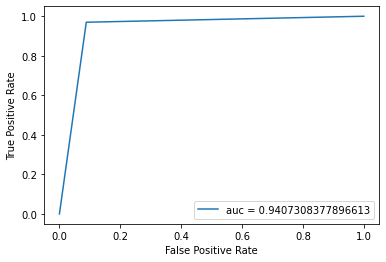

In [19]:
# ROC 커브 시각화

fpr, tpr, _ = roc_curve(y_test, predictions)
auc = roc_auc_score(y_test, predictions)
plt.plot(fpr, tpr, label = 'auc = ' + str(auc))
plt.legend(loc = 'lower right')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

## 전체 분류 모델 성능 지표

In [20]:
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1_score = f1_score(y_test, predictions)
auc_score = roc_auc_score(y_test, predictions)

print('accuracy: {}'.format(round(accuracy, 2)))
print('precision: {}'.format(round(precision, 2)))
print('recall: {}'.format(round(recall, 2)))
print('f1_score: {}'.format(round(f1_score, 2)))
print('auc_score: {}'.format(round(auc_score, 2)))

accuracy: 0.94
precision: 0.91
recall: 0.97
f1_score: 0.94
auc_score: 0.94
